##**Task1 KNN**

#Libraries


In [223]:
import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import time
import random
import scipy as sp
from scipy.spatial import distance
from collections import Counter
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import math
from scipy.spatial.distance import mahalanobis

#Reading CSV as dataframe

In [224]:
#Reading CSV setting header None so that first row is not taken as header
Imagedf = pd.read_csv('/content/fea.csv',header=None)

In [225]:
#converting to dataframe with index as list from 0 to 1699 to be able to read in row
df = pd.DataFrame(Imagedf,index= list(range(1700)))
#df

#Normalizing Data

In [226]:
#Function to find magnitude for given instance/image. it accepts 1-D array
def magnitude(imgarray):
  magnitudevalue = 0
  for i in imgarray:
    magnitudevalue += math.pow(i,2);
  return np.sqrt(magnitudevalue)

In [227]:
#converting dataframe to numpy array for mathematical calculation
imagesArray = np.array(df)

#Normalizing each instance by dividing it with magnitude
Normalized_array = np.empty((1700, 1024))
for index in range(len(imagesArray)):
  Normalized_array[index] = imagesArray[index] / magnitude(imagesArray[index])





#Creatin Subjects/Buckets

In [228]:
#Each subject have 170 images representing each different group
subjects = []
for value in range(0,1700,170):
  subjects.append(Normalized_array[value:value+170])

print("Total Subjects/buckets: ",len(subjects))
print("Images in bucket: ",len(subjects[0]))

Total Subjects/buckets:  10
Images in bucket:  170


#KNN Model with all three distances

In [229]:
class KNN():

  __test_subject_size = 0
  __train_subject_size = 0
  __predict_list = []
  k=0
  train_data = []
  test_data = []
  
  
  #Constructor which will load initial data
  def __init__(self,train_data,test_data):
     
    self.train_data = train_data
    self.test_data = test_data
    
    
    self.__test_subject_size = int(len(test_data)/10)
    self.__train_subject_size = int(len(train_data)/10)
    self.__predict_list = [[value, 0] for value in [0] * self.__test_subject_size + [1] * self.__test_subject_size + [2] * self.__test_subject_size + [3] * self.__test_subject_size + [4] * self.__test_subject_size + [5] * self.__test_subject_size + [6] * self.__test_subject_size + [7] * self.__test_subject_size + [8] * self.__test_subject_size + [9] * self.__test_subject_size]
    self.__distances_list = [[value, 0] for value in [0] * self.__train_subject_size + [1] * self.__train_subject_size + [2] * self.__train_subject_size + [3] * self.__train_subject_size + [4] * self.__train_subject_size + [5] * self.__train_subject_size + [6] * self.__train_subject_size + [7] * self.__train_subject_size + [8] * self.__train_subject_size + [9] * self.__train_subject_size]
    
  #Calculate distance default='euclidean' or you can pass other two while calling this function
  def CalculateDistance(self,category='euclidean'):
    
    if(category.lower()=='cosine'):

      for imgindex in tqdm(range(0,len(self.test_data))):
        test_img = self.test_data[imgindex]
        mag_test = magnitude(test_img)
        #distance_list store distance between test image and each train image
        for i in range(len(self.train_data)):
          dotproduct = np.dot(self.train_data[i],test_img)
          self.__distances_list[i][1] = 1-(dotproduct/(mag_test*(magnitude(self.train_data[i]))))

        #sorted list contains sorted values of distance_list in ascending order   
        sorted_list = sorted(self.__distances_list, key=lambda x: x[1])
        #selecting k nearest neigbours and counting most repeated class
        most_common_value = Counter([item[0] for item in sorted_list[:self.k]]).most_common(1)[0][0]
        #storing prediction of KNN for given image
        self.__predict_list[imgindex][1] = most_common_value

    
    elif(category.lower()=='mahalanobis'):
      cov_train = (pd.DataFrame(self.train_data)).cov().values
      print("in")
      for imgindex in tqdm(range(0,len(self.test_data))):
        test_img = self.test_data[imgindex]
        for i in range(len(self.train_data)):
          V = np.cov(np.array([test_img, self.train_data[i]]))
          IV = np.linalg.inv(cov_train)
          
          self.__distances_list[i][1] = mahalanobis(test_img, self.train_data[i], IV)
          

        sorted_list = sorted(self.__distances_list, key=lambda x: x[1])
        #selecting k nearest neigbours and counting most repeated class
        most_common_value = Counter([item[0] for item in sorted_list[:self.k]]).most_common(1)[0][0]
        #storing prediction of KNN for given image
        self.__predict_list[imgindex][1] = most_common_value
    
    
    else:
      for imgindex in tqdm(range(0,len(self.test_data))):
        for i in range(len(self.train_data)):
          
          squared_diff = np.square(self.test_data[imgindex] - self.train_data[i])
          sum_squared_diff = np.sum(squared_diff)
          distance = np.sqrt(sum_squared_diff)
          
          self.__distances_list[i][1] = distance
        
        sorted_list = sorted(self.__distances_list, key=lambda x: x[1])
        counter = Counter([item[0] for item in sorted_list[:self.k]])
        most_common_value = counter.most_common(1)[0][0]
        self.__predict_list[imgindex][1] = most_common_value

  def Predict(self):
    print("Predicted array",self.__predict_list)
    count = 0

    for item in self.__predict_list:
        if item[0] == item[1]:
            count += 1
    accuracy = (count/len(self.test_data))*100
    print("Accuracy: ",accuracy)
    return accuracy

#Split Data
Passed Data will be splited n number of time.
bucket can have given number of training images

In [230]:
#split data function which will split data for given number and it will have given number of train_images
#number = folds, images = 150
def split_data(datatosplit,number,train_image_per_subject):
  random.seed(42)
  random_splits = []
  
  for fold in range(number):
      train_data = []
      test_data = []

      
      # from each subject spliting data 
      for i in range(0,len(datatosplit)):
          
          image_indices = list(range(len(datatosplit[i])))
          
          # Randomly select 150 images for training
          train_indexes = random.sample(image_indices, train_image_per_subject)
          train_data.extend((datatosplit[i])[train_indexes])
        
          # Use the remaining images for testing
          test_indexes = [index for index in image_indices if index not in train_indexes]
          test_data.extend((datatosplit[i])[test_indexes])
      
      random_splits.append([train_data,test_data])
  return random_splits

In [231]:
def Apply_KNN(splited_data,k_list,method='ecludien'):
  comparison_matrix = []
  
  for splitnumber,split in enumerate(splited_data):
    #KNN class object feeding each subject train and test data
    knn_obj = KNN(split[0],split[1])
    
    for k_value in k_list:
      start_time = time.time()
      print("Performing fold number {} with value of K as {}".format(splitnumber+1,k_value))
      #knn_obj = KNN(split[0],split[1],k_value)
      knn_obj.k = k_value
      knn_obj.CalculateDistance(method)
      finish_time = time.time()
      print("Execution time: ",finish_time-start_time)
      
      comparison_matrix.append([splitnumber+1,k_value,knn_obj.Predict()])
  return comparison_matrix

#Applying KNN on each value in K_list

In [232]:
#creating 3 splits and each subject will have 150 images
splits = split_data(subjects,3,150)
k_list = [10,20,30]
comparison_matrix = Apply_KNN(splits,k_list,'ecludien')


Performing fold number 1 with value of K as 10


100%|██████████| 200/200 [00:03<00:00, 61.11it/s]


Execution time:  3.2785794734954834
Predicted array [[0, 0], [0, 0], [0, 0], [0, 8], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [1, 8], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 7], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [2, 7], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [3, 3], [3, 8], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 5], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [4, 4], [4, 7], [4, 6], [4, 6], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [5, 0], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5,

100%|██████████| 200/200 [00:03<00:00, 61.62it/s]


Execution time:  3.2558603286743164
Predicted array [[0, 0], [0, 0], [0, 0], [0, 8], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [1, 8], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 7], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 7], [1, 7], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [2, 4], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [3, 2], [3, 8], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [4, 4], [4, 7], [4, 4], [4, 7], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [5, 0], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5,

100%|██████████| 200/200 [00:03<00:00, 59.86it/s]


Execution time:  3.3527743816375732
Predicted array [[0, 0], [0, 0], [0, 0], [0, 8], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [1, 8], [1, 6], [1, 1], [1, 6], [1, 1], [1, 1], [1, 7], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [2, 4], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [3, 2], [3, 8], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [4, 4], [4, 7], [4, 4], [4, 7], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 7], [4, 4], [4, 4], [4, 8], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5,

100%|██████████| 200/200 [00:03<00:00, 55.65it/s]


Execution time:  3.6003918647766113
Predicted array [[0, 0], [0, 0], [0, 0], [0, 8], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [1, 8], [1, 1], [1, 1], [1, 1], [1, 8], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [3, 2], [3, 8], [3, 3], [3, 3], [3, 3], [3, 3], [3, 0], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [4, 4], [4, 4], [4, 7], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [5, 0], [5, 6], [5, 0], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5,

100%|██████████| 200/200 [00:03<00:00, 63.57it/s]


Execution time:  3.1509335041046143
Predicted array [[0, 0], [0, 0], [0, 0], [0, 8], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [1, 8], [1, 1], [1, 1], [1, 7], [1, 8], [1, 8], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 7], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [3, 2], [3, 8], [3, 3], [3, 3], [3, 5], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [4, 1], [4, 4], [4, 7], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 6], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [5, 0], [5, 8], [5, 0], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5,

100%|██████████| 200/200 [00:03<00:00, 63.00it/s]


Execution time:  3.179706573486328
Predicted array [[0, 0], [0, 0], [0, 0], [0, 8], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [1, 1], [1, 1], [1, 1], [1, 7], [1, 8], [1, 8], [1, 1], [1, 1], [1, 1], [1, 4], [1, 7], [1, 1], [1, 1], [1, 7], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [3, 2], [3, 7], [3, 3], [3, 8], [3, 8], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [4, 1], [4, 4], [4, 7], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 6], [4, 4], [4, 4], [4, 4], [4, 4], [4, 8], [4, 4], [4, 4], [4, 4], [5, 5], [5, 8], [5, 0], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 

100%|██████████| 200/200 [00:03<00:00, 55.95it/s]


Execution time:  3.584882974624634
Predicted array [[0, 0], [0, 8], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [1, 7], [1, 7], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [2, 2], [2, 7], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [3, 3], [3, 8], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [5, 4], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 

100%|██████████| 200/200 [00:03<00:00, 61.65it/s]


Execution time:  3.250190019607544
Predicted array [[0, 0], [0, 8], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [1, 8], [1, 7], [1, 7], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 4], [1, 1], [1, 1], [1, 1], [1, 7], [1, 1], [1, 6], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [2, 2], [2, 7], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [3, 3], [3, 8], [3, 7], [3, 3], [3, 5], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 6], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [5, 4], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 

100%|██████████| 200/200 [00:03<00:00, 63.81it/s]

Execution time:  3.1467206478118896
Predicted array [[0, 0], [0, 8], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 2], [1, 7], [1, 7], [1, 7], [1, 1], [1, 7], [1, 1], [1, 1], [1, 1], [1, 4], [1, 1], [1, 1], [1, 1], [1, 7], [1, 1], [1, 6], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [2, 2], [2, 7], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [3, 3], [3, 8], [3, 7], [3, 3], [3, 8], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 1], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 6], [4, 4], [4, 4], [4, 4], [4, 8], [4, 8], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [5, 4], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5,

#Comparison Plot

In [233]:
# I copied heatmap code from google
 
# Separate value from each coloums so that we can compare it easily
def plot_accuracy(comparison_matrix):
    column1 = [item[0] for item in comparison_matrix]
    column2 = [item[1] for item in comparison_matrix]
    column3 = [item[2] for item in comparison_matrix]



    # Create a pivot table to reshape the data for heatmap
    pivot_table = np.zeros((len(np.unique(column1)), len(np.unique(column2))))
    for i, c1 in enumerate(np.unique(column1)):
        for j, c2 in enumerate(np.unique(column2)):
            value = [item[2] for item in comparison_matrix if item[0] == c1 and item[1] == c2]
            if value:
                pivot_table[i, j] = value[0]

    # Create a heatmap using Seaborn
    sns.heatmap(pivot_table, annot=True, fmt='.1f')#, cmap='viridis')

    # Set axis labels and title
    plt.xlabel('K-value')
    plt.ylabel('Folds')
    plt.title('Comparison of Accuracy based on Folds and K-value')

    plt.xticks(np.arange(len(np.unique(column2))) + 0.5, np.unique(column2))
    plt.yticks(np.arange(len(np.unique(column1))) + 0.5, np.unique(column1))

    plt.show()

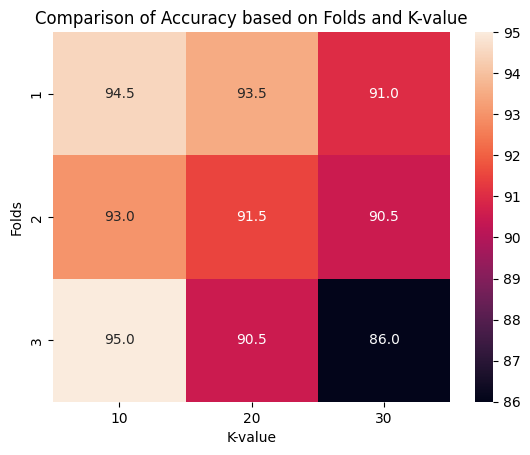

In [234]:
plot_accuracy(comparison_matrix)

0

0

0

# **Task 02**

---



# **Task2 Principal Component Analysis**





In [235]:
Normalized_array

array([[0.0217957 , 0.02802305, 0.02802305, ..., 0.00560461, 0.00560461,
        0.00560461],
       [0.00623682, 0.00575707, 0.00527731, ..., 0.03214361, 0.02974484,
        0.02782582],
       [0.0070847 , 0.00885587, 0.01180783, ..., 0.00531352, 0.00472313,
        0.00413274],
       ...,
       [0.00772975, 0.00687089, 0.00515317, ..., 0.01202406, 0.01975382,
        0.02576585],
       [0.00811554, 0.00631209, 0.00541036, ..., 0.02254317, 0.01893626,
        0.0234449 ],
       [0.01565356, 0.01304464, 0.01130535, ..., 0.01739285, 0.0226107 ,
        0.01478392]])

##PCA which takes two parameter one is data on which PCA is to be applied. Second is upto what percent your data is defined by defined by features. by defualt its '90'.

In [236]:
def PCA_m(data,req_percentage=90):
  data_meaned = data - np.mean(data , axis = 0)
  data_cov_mat = np.cov(data_meaned , rowvar = False)
  data_eigen_values , data_eigen_vectors = np.linalg.eigh(data_cov_mat)
  sorted_index = np.argsort(data_eigen_values)[::-1]
  sorted_eigenvalue = data_eigen_values[sorted_index]
  #similarly sort the eigenvectors 
  sorted_eigenvectors = data_eigen_vectors[:,sorted_index]

  cumulative_sum = np.cumsum(sorted_eigenvalue)
  index = np.argmax(cumulative_sum >= (req_percentage/100)*data_eigen_values.sum()) + 1

  eigenvector_subset = sorted_eigenvectors[:,0:index]
     
  
  X_reduced = np.dot(eigenvector_subset.transpose() , data_meaned.transpose() ).transpose()
  reduced_cov_mat = np.cov(X_reduced , rowvar = False)
  return X_reduced,reduced_cov_mat


def plot_covaraince_matrix(matrix,bef_aft):
  plt.figure(figsize=(8, 6))
  plt.imshow(matrix, cmap='icefire', interpolation='nearest')
  plt.colorbar()
  title = str("Covariance Matrix Heatmap {} PCA").format(bef_aft)
  plt.title(title)
  plt.xlabel('Features')
  plt.ylabel('Features')
  plt.show()

##Plotting Covaraince before applying PCA

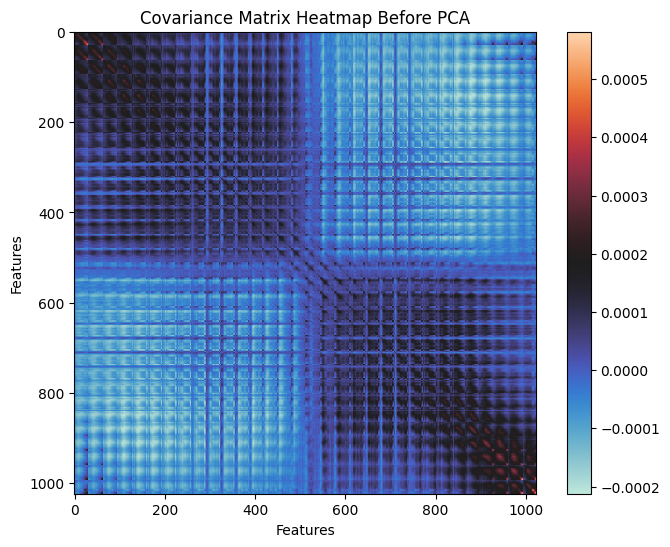

In [237]:
#subtracting each feature/coloum with its mean
data_meaned = Normalized_array - np.mean(Normalized_array , axis = 0)
# calculating the covariance matrix of the mean-centered data.
data_cov_mat = np.cov(data_meaned , rowvar = False)
plot_covaraince_matrix(data_cov_mat,"Before")

##PCA applied to find features which define 90 percent of data

##Ploting Covariance after PCA applied

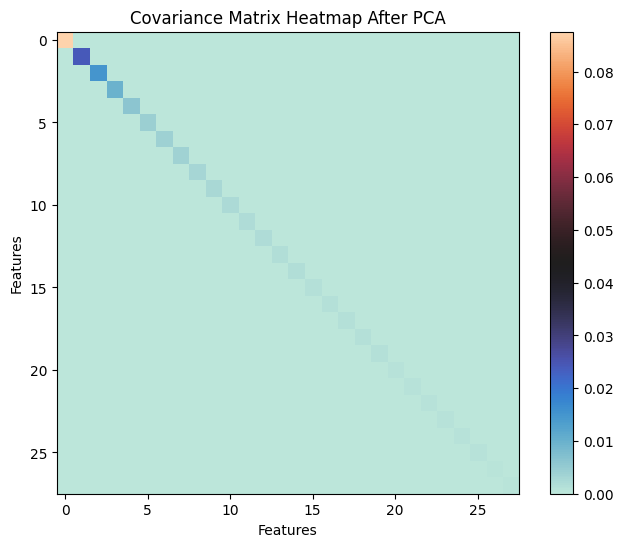

In [238]:
reduced_data,reduced_data_covariance = PCA_m(Normalized_array,90)
plot_covaraince_matrix(reduced_data_covariance,"After")

##Dimension of reduced features

##90 percent of data is defined by only 28 features. 

In [239]:
print("PCA reduced dimention to: ",reduced_data.shape)

PCA reduced dimention to:  (1700, 28)


##Applying KNN or reduced_data

In [240]:
reduced_subjects = []
for value in range(0,1700,170):
  reduced_subjects.append(reduced_data[value:value+170])


red_splits = split_data(reduced_subjects,3,150)

print("Performing KNN on Reduced data by PCA\n\n")
red_comparison_matrix = Apply_KNN(red_splits,k_list,'ecludien')

Performing KNN on Reduced data by PCA


Performing fold number 1 with value of K as 10


100%|██████████| 200/200 [00:02<00:00, 78.48it/s]


Execution time:  2.5617051124572754
Predicted array [[0, 2], [0, 0], [0, 0], [0, 2], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [1, 8], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [2, 4], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [3, 3], [3, 8], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 5], [3, 3], [3, 3], [3, 3], [3, 0], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [4, 4], [4, 7], [4, 6], [4, 6], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 7], [5, 5], [5, 5], [5, 5], [5, 5], [5,

100%|██████████| 200/200 [00:02<00:00, 67.74it/s]


Execution time:  2.9615814685821533
Predicted array [[0, 0], [0, 0], [0, 0], [0, 2], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [1, 8], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 7], [1, 6], [1, 1], [1, 1], [1, 1], [1, 1], [1, 4], [1, 7], [1, 6], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [2, 4], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [3, 2], [3, 8], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [4, 4], [4, 7], [4, 4], [4, 7], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [5, 0], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5,

100%|██████████| 200/200 [00:02<00:00, 82.28it/s]


Execution time:  2.44274640083313
Predicted array [[0, 0], [0, 0], [0, 0], [0, 8], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [1, 8], [1, 6], [1, 1], [1, 6], [1, 1], [1, 1], [1, 7], [1, 6], [1, 1], [1, 1], [1, 1], [1, 1], [1, 6], [1, 4], [1, 4], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [2, 4], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [3, 2], [3, 8], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 2], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [4, 4], [4, 7], [4, 4], [4, 7], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 2], [4, 7], [4, 4], [4, 8], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 7], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 0], [5, 5], [5, 5

100%|██████████| 200/200 [00:02<00:00, 82.34it/s]


Execution time:  2.439542770385742
Predicted array [[0, 0], [0, 0], [0, 0], [0, 2], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [1, 1], [1, 1], [1, 1], [1, 7], [1, 8], [1, 8], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [3, 2], [3, 8], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [4, 4], [4, 6], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [5, 5], [5, 8], [5, 0], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 

100%|██████████| 200/200 [00:02<00:00, 81.71it/s]


Execution time:  2.4559364318847656
Predicted array [[0, 0], [0, 0], [0, 0], [0, 8], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [1, 1], [1, 1], [1, 1], [1, 7], [1, 8], [1, 8], [1, 1], [1, 1], [1, 1], [1, 4], [1, 2], [1, 6], [1, 1], [1, 7], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [3, 2], [3, 8], [3, 3], [3, 3], [3, 5], [3, 3], [3, 3], [3, 0], [3, 2], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [4, 4], [4, 1], [4, 7], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [5, 0], [5, 8], [5, 0], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5,

100%|██████████| 200/200 [00:02<00:00, 72.51it/s]


Execution time:  2.77362060546875
Predicted array [[0, 0], [0, 2], [0, 0], [0, 8], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [1, 1], [1, 1], [1, 1], [1, 8], [1, 8], [1, 8], [1, 1], [1, 8], [1, 1], [1, 4], [1, 7], [1, 4], [1, 1], [1, 7], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [3, 2], [3, 8], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 0], [3, 2], [3, 0], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [4, 4], [4, 4], [4, 7], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 6], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [5, 5], [5, 8], [5, 0], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5

100%|██████████| 200/200 [00:02<00:00, 74.40it/s]


Execution time:  2.6963515281677246
Predicted array [[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [1, 8], [1, 8], [1, 1], [1, 1], [1, 7], [1, 1], [1, 1], [1, 1], [1, 4], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [2, 2], [2, 7], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [5, 4], [5, 5], [5, 8], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5,

100%|██████████| 200/200 [00:03<00:00, 61.33it/s]


Execution time:  3.272392749786377
Predicted array [[0, 0], [0, 8], [0, 3], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [1, 8], [1, 8], [1, 7], [1, 1], [1, 7], [1, 1], [1, 1], [1, 1], [1, 4], [1, 1], [1, 1], [1, 1], [1, 6], [1, 4], [1, 4], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [2, 2], [2, 7], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [3, 3], [3, 8], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 1], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 8], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [5, 4], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 

100%|██████████| 200/200 [00:03<00:00, 61.68it/s]

Execution time:  3.2536447048187256
Predicted array [[0, 0], [0, 8], [0, 3], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [1, 8], [1, 7], [1, 7], [1, 1], [1, 7], [1, 1], [1, 1], [1, 1], [1, 4], [1, 1], [1, 1], [1, 1], [1, 6], [1, 6], [1, 6], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [2, 2], [2, 7], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [3, 3], [3, 8], [3, 2], [3, 8], [3, 8], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 1], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 6], [4, 4], [4, 4], [4, 4], [4, 4], [4, 8], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [5, 4], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5,

##Accuracy of KNN upon reduced_data

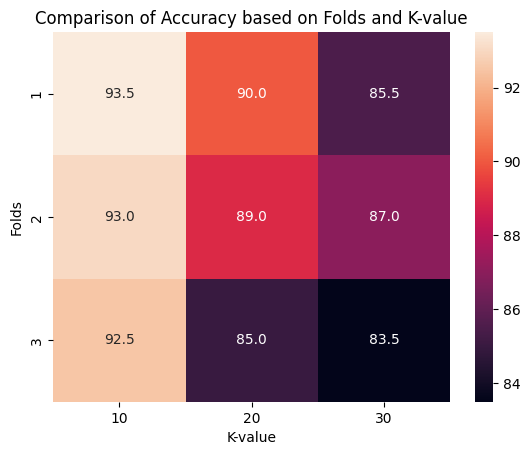

In [241]:
plot_accuracy(red_comparison_matrix)

##Applying Built In PCA

##PCA parameter is how much data must be defind by PCA

In [242]:
principal=PCA(.90)
principal.fit(Normalized_array)
x=principal.transform(Normalized_array)
 
# Check the dimensions of data after PCA
print(x.shape)

(1700, 28)


In [243]:
x_cov = np.cov(x,rowvar=False)

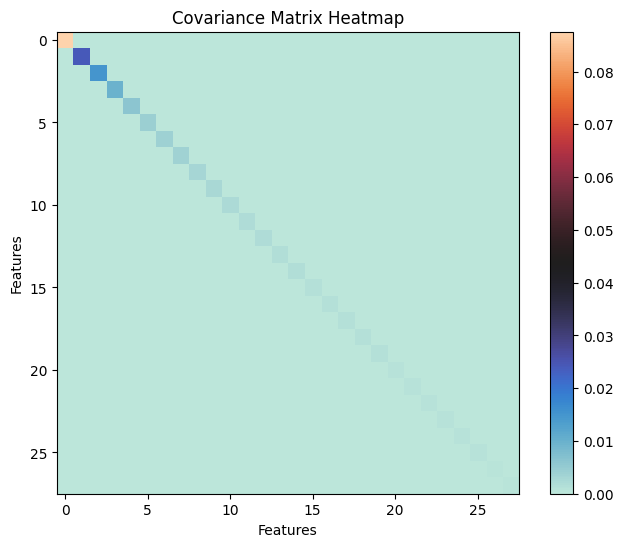

In [244]:
plt.figure(figsize=(8, 6))
plt.imshow(x_cov, cmap='icefire', interpolation='nearest')
plt.colorbar()
plt.title('Covariance Matrix Heatmap')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()  

##Applying KNN on features reduced by IN-Built PCA

In [245]:
#creating 3 splits and each subject will have 150 images
inbuilt_subjects = []
for value in range(0,1700,170):
  inbuilt_subjects.append(x[value:value+170])


in_splits = split_data(inbuilt_subjects,3,150)
inbuilt_comparison_matrix = Apply_KNN(in_splits,k_list,'ecludien')

Performing fold number 1 with value of K as 10


100%|██████████| 200/200 [00:03<00:00, 66.34it/s]


Execution time:  3.019369125366211
Predicted array [[0, 2], [0, 0], [0, 0], [0, 2], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [1, 8], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [2, 4], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [3, 3], [3, 8], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 5], [3, 3], [3, 3], [3, 3], [3, 0], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [4, 4], [4, 7], [4, 6], [4, 6], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 7], [5, 5], [5, 5], [5, 5], [5, 5], [5, 

100%|██████████| 200/200 [00:02<00:00, 80.86it/s]


Execution time:  2.483849287033081
Predicted array [[0, 0], [0, 0], [0, 0], [0, 2], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [1, 8], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 7], [1, 6], [1, 1], [1, 1], [1, 1], [1, 1], [1, 4], [1, 7], [1, 6], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [2, 4], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [3, 2], [3, 8], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [4, 4], [4, 7], [4, 4], [4, 7], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [5, 0], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 

100%|██████████| 200/200 [00:02<00:00, 80.02it/s]


Execution time:  2.5099759101867676
Predicted array [[0, 0], [0, 0], [0, 0], [0, 8], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [1, 8], [1, 6], [1, 1], [1, 6], [1, 1], [1, 1], [1, 7], [1, 6], [1, 1], [1, 1], [1, 1], [1, 1], [1, 6], [1, 4], [1, 4], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [2, 4], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [3, 2], [3, 8], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 2], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [4, 4], [4, 7], [4, 4], [4, 7], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 2], [4, 7], [4, 4], [4, 8], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 7], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 0], [5, 5], [5,

100%|██████████| 200/200 [00:02<00:00, 81.17it/s]


Execution time:  2.4756617546081543
Predicted array [[0, 0], [0, 0], [0, 0], [0, 2], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [1, 1], [1, 1], [1, 1], [1, 7], [1, 8], [1, 8], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [3, 2], [3, 8], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [4, 4], [4, 6], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [5, 5], [5, 8], [5, 0], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5,

100%|██████████| 200/200 [00:02<00:00, 75.11it/s]


Execution time:  2.67433500289917
Predicted array [[0, 0], [0, 0], [0, 0], [0, 8], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [1, 1], [1, 1], [1, 1], [1, 7], [1, 8], [1, 8], [1, 1], [1, 1], [1, 1], [1, 4], [1, 2], [1, 6], [1, 1], [1, 7], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [3, 2], [3, 8], [3, 3], [3, 3], [3, 5], [3, 3], [3, 3], [3, 0], [3, 2], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [4, 4], [4, 1], [4, 7], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [5, 0], [5, 8], [5, 0], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5

100%|██████████| 200/200 [00:02<00:00, 71.27it/s]


Execution time:  2.811861753463745
Predicted array [[0, 0], [0, 2], [0, 0], [0, 8], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [1, 1], [1, 1], [1, 1], [1, 8], [1, 8], [1, 8], [1, 1], [1, 8], [1, 1], [1, 4], [1, 7], [1, 4], [1, 1], [1, 7], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [3, 2], [3, 8], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 0], [3, 2], [3, 0], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [4, 4], [4, 4], [4, 7], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 6], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [5, 5], [5, 8], [5, 0], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 

100%|██████████| 200/200 [00:02<00:00, 81.16it/s]


Execution time:  2.4729971885681152
Predicted array [[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [1, 8], [1, 8], [1, 1], [1, 1], [1, 7], [1, 1], [1, 1], [1, 1], [1, 4], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [2, 2], [2, 7], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [5, 4], [5, 5], [5, 8], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5,

100%|██████████| 200/200 [00:02<00:00, 81.03it/s]


Execution time:  2.4792494773864746
Predicted array [[0, 0], [0, 8], [0, 3], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [1, 8], [1, 8], [1, 7], [1, 1], [1, 7], [1, 1], [1, 1], [1, 1], [1, 4], [1, 1], [1, 1], [1, 1], [1, 6], [1, 4], [1, 4], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [2, 2], [2, 7], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [3, 3], [3, 8], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 1], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 8], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [5, 4], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5,

100%|██████████| 200/200 [00:02<00:00, 81.15it/s]

Execution time:  2.4757025241851807
Predicted array [[0, 0], [0, 8], [0, 3], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [1, 8], [1, 7], [1, 7], [1, 1], [1, 7], [1, 1], [1, 1], [1, 1], [1, 4], [1, 1], [1, 1], [1, 1], [1, 6], [1, 6], [1, 6], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [2, 2], [2, 7], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [3, 3], [3, 8], [3, 2], [3, 8], [3, 8], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 1], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 6], [4, 4], [4, 4], [4, 4], [4, 4], [4, 8], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [5, 4], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5, 5], [5,

##KNN result on In-Built PCA reduced data

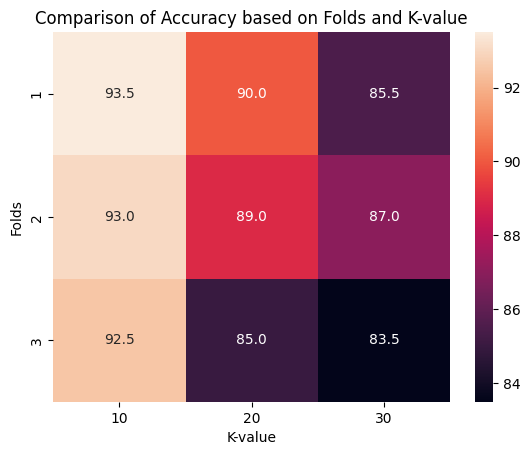

In [246]:
plot_accuracy(inbuilt_comparison_matrix)